In [1]:
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from transformer_mt.modeling_attention import MultiHeadAttention
from transformer_mt.modeling_transformer import TransformerDecoderLayer, TransfomerEncoderDecoderModel

# Transformer Decoder

In the last homework, we built Transformer Encoder Model. In this Homework, you will learn how to build a decoder block and a sequence-to-sequence (seq2seq) model. Sequence-to-sequence is a type of model that accepts a sequence of tokens and outputs a sequence (in general, of different lengths). It can be implemented in multiple ways, using recurrent neural networks or even convolutional networks, but Transformer-based seq2seq is the most successful one.

Each seq2seq consists of an encoder and a decoder. Each usually consists of multiple layers.

For transformers, each decoder block consists of three main parts 1) Self-attention 2) Cross-attention 3) Feedforward network. The below image depicts details of both encoder and decoder blocks.  
Reference- https://jalammar.github.io/illustrated-transformer/

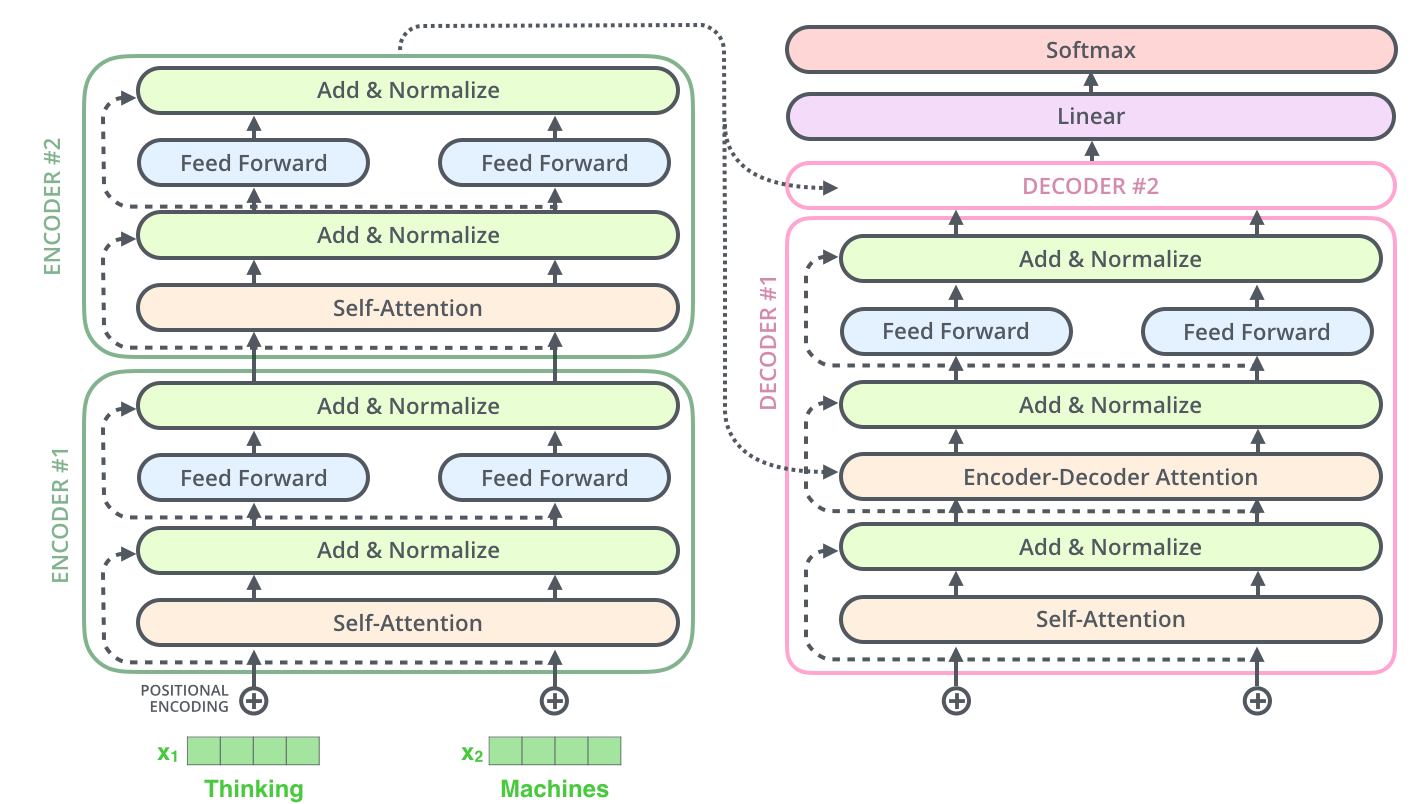

Before moving forward, we need to understand two types of attention.

- `Self-attention` - It is an attention of sequence to itself. The keys, queries, and values are all produced from the same input sequence.

$$
\operatorname{SelfAttention}(x) = \operatorname{Softmax \left(\frac{xQ (xK)^T}{\sqrt{h}}\right) xV}
$$

here, $K, Q, V \in \mathbb{R}^{input\_size \times hidden}$ -- parameter matrices. Usually, they have the same shape, though technically, `hidden` of V matrix could be different from `hidden` of K and Q.

- `Cross-attention` - It is attention between two sequences. If a query is produced from the attending (source) sequence and keys and values are generated from the attended (target) sequence, then the computed attention is called cross attention. This operation has two inputs: source (attending) sequence and target (attended) sequence.


$$
\operatorname{CrossAttention}(s, t) = \operatorname{Softmax \left(\frac{sQ (tK)^T}{\sqrt{h}}\right) tV}
$$

here, $K, V \in \mathbb{R}^{target\_size \times hidden}$ and $K, $Q \in \mathbb{R}^{soruce\_size \times hidden}$. Usually, target\_size is the same as input\_size.

Where does the directionality come from? Why do we say that source attends to target and not the opposite? Because the target shape is [source\_seq, hidden]. Every source query has attended to every target key and summed all of the target values with the attention weights.

Also, notice that

$$
\operatorname{CrossAttention}(x, x) = \operatorname{SelfAtteniton(x)}
$$

Even though self-attention and cross-attention look so similar, they are used for quite different reasons. Self-attention is used to extract the features from a sequence, learn relations. Cross-attention is an operation that allows two different sequences to interact. For example, if you are translating

```
english_sentence = [A, red, hat]
```

from English to French and currently, you have only translated the first 2 words and your translation right now looks like

```
french_translation = [BOS, Une, chapeau]
```

You would want the French translation to attend to the English sentence

$$
\operatorname{CrossAttention}(english\_sentence, french\_translation)
$$

In transformers, we use self-attention (multi-head self-attention to be specific) in an **encoder** and cross attention in a **decoder** block.
Self-attention is depicted as `Self-Attention` in the above figure's encoder block.
Cross attention is depicted as `Encoder-Decoder Attention` in the above figure's decoder block. However, we also see another `Self-Attention` in the decoder block. Here is the difference

- `Self-Attention in Encoder` - Input is the input sequence and there is no causal masking because during translation (or most of the seq2seq tasks in general) we always have access to the whole input sentence.
- `Self-Attention in Decoder` - Input is the target sequence and causal masking is on to avoid seeing future tokens in the target sequence during training (as they are not available at test time).

Our current implementation of `MultiHeadAttention` class can only function like Self-Attention, it needs to be modified to be able to include cross attention.

Therefore before moving on to create the decoder layer we need to first modify our `MultiHeadAttention` class and include a cross-attention mechanism to it. 

We will first add cross-attention to the `MultiHeadAttention` class, then use this to build the decoder layer class `TransformerDecoderLayer` and then use both the `TransformerEncoderLayer` and `TransformerDecoderLayer` class to create `TransfomerEncoderDecoderModel`.

**This Homework consists of three parts-** 
* **Coding Task 1** - Include Cross Attention in the `MultiHeadAttention` class. Notice that it is almost exactly the same operation. The whole difference is that cross-attention has a second input. Also, remember that self-attention is a particular case of cross-attention.
* **Coding Task 2** - Complete `TransformerDecoderLayer` class
* **Coding Task 3** - Complete `TransfomerEncoderDecoderModel` class


**NOTE:** the words **source** and **target** can be misleading if you do not specify the context. In the context of machine translation **source** sentence is an input sentence that you want to translate and the **target** sentence is the one you want to get from the system (the translation). In the context of attention **source** is the sequence that attends and **target** is the sequence that is **being attended to**. This creates a terrible situation that when the **target sentence** attending to the **source sentence** (as it does in the decoder) will actually be a **target** (in the sense of attention). For this reason, we try to minimize the use of these words for attention.


# Coding task 1.1
## Include Cross Attention in the MultiHeadAttention() class

MultiHeadAttention class needs to act differently depending on where it is placed. If placed in
- MultiHeadAttention in Encoder does `Self-Attention` 
- MultiHeadAttention in Decoder first sublayer does `Self-Attention` with causal masking
- MultiHeadAttention in Decoder second sublayer does `Cross Attention`

In previous homework, you built `MultiHeadAttention` class which can perform `SelfAttention` along with a causal masking feature. In this homework, you need to modify this class and add another input called 'target', and based on whether it is being used in encoder or decoder, it should act like self-attention with or without causal or cross attention.

Modify the `MultiheadAttention(input_size, hidden_size, num_heads)` class in `transformer_mt/modeling_trasnformer.py` which accepts `FloatTensor[bs, seq_len, input_size]` and returns `FloatTensor[bs, seq_len, hidden_size]` to include cross attention mechanism. `bs` stands for batch size and `seq_len` is input sequence length. 

Please read https://jalammar.github.io/illustrated-transformer for more details.

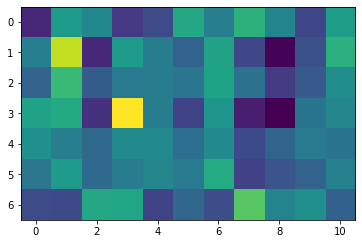

In [2]:
input_size = 9
hidden = 15
num_heads = 3
batch_size = 5
soruce_seq_len = 7
target_seq_len = 11

model = MultiHeadAttention(input_size=input_size, hidden=hidden, num_heads=num_heads)
attending_sequence = torch.randn(batch_size, soruce_seq_len, input_size)
attended_sequence = torch.randn(batch_size, target_seq_len, input_size)

att, probs = model(q=attending_sequence, kv=attended_sequence, return_attention=True)

assert att.shape == (batch_size, soruce_seq_len, hidden), att.shape
assert probs.shape == (batch_size * num_heads, soruce_seq_len, target_seq_len), probs.shape

plt.imshow(torch.softmax(probs[0], dim=-1).detach().numpy())
plt.show()
assert probs[0, 0, 3].item() > 1e-10

# Coding task 1.2
## Padding

Sentences can have different lengths, but we still want to process them together in a single batch. Unfortunately, tensors are dense contiguous entities and every example in a batch should be of exactly the same length. To overcome this issue, we can pad all sequences inside the batch to the same length.

For example, if you have two sentences:

* They like ice cream
* A house with a red roof

They have the lengths 4 and 6 (assume token == word) and can have `sequence_id` like this

```
first_sentence  = [4,  9, 45, 3]
second_sentence = [3, 85, 99, 3, 23, 48]
```

In order to put them together into a tensor of shape `[batch_size=2, seq_len=6]` we need to pad the first one with a special PAD token. It's very common to have pad token index equal to 0 (but in general you can select anything).

```
first_sentence =  [4,  9, 45, 3,  0,  0]
second_sentence = [3, 85, 99, 3, 23, 48]
```

which allows to combine them into a single tensor

```
input_ids = [
    [4,  9, 45, 3,  0,  0],
    [3, 85, 99, 3, 23, 48],
]
```

You will implement this in `train.py` later, but now we need to decide how to handle this on the model side. In general, one of the solutions would be to do nothing. However, then the model needs to learn that PAD tokens are useless and it's going to waste some time on that. Also in this case we have no guarantee that the sentence [A red roof PAD] will be processed in exactly the same way as a sentence [A red roof PAD PAD PAD PAD]. In general, we want our models to only learn what they need to learn and there is no reason for them to learn padding.

A trick that people use for padding is very similar to the trick we used for causal masking. We want to restrict the attention from looking at particular tokens (thus, the outputs of attention being affected by these tokens). Unlike causal masking which restricts token at a position i to look at token at a position j if j > i, pad-masking does not depend on relative positions. We do not want *any* of the tokens to look at padding. This simplifies the masking process quite a bit.

So, if we have attention scores ($s = xQ (xK)^T$) of shape `[attending_seq_len=6, attended_seq_len=6]` and the first sequence in the batch has the last two tokens padded, we want to have a mask for it that has the following property:

* None of the attending tokens can attend to padded tokens

Mathematically it means that for every `i` and `j` we want `s[i, j]` to be equal `-inf` if `j` is padded. A mask corresponding to this where 1 means padding and 0 means no padding can look like this

```
[[0., 0., 0., 0., 1., 1.],
 [0., 0., 0., 0., 1., 1.],
 [0., 0., 0., 0., 1., 1.],
 [0., 0., 0., 0., 1., 1.],
 [0., 0., 0., 0., 1., 1.],
 [0., 0., 0., 0., 1., 1.]]
```

Then, inside the module, before computing softmax, you want to apply this mask in exactly the same way as you did with the causal mask in the previous homework. To make all scores that have 1 in the mask equal to `-inf`. This will make their softmax probabilities exactly 0.

> Potential issues: what if we additionally restrict the padding tokens to attend to anything? Imagine the last two rows of the matrix above to be all 1. Would it lead to a problem? Yes, in this case the value of softmax will be equal to NaN, because the denominator $\sum e^{s_i} = \sum e^{-\inf} = 0$.

Unlike causal masking which always works the same and does not depend on the input content, padding mask does. So you need to pass an additional input to your attention module -- padding mask. Additionally, because the mask is applied in exactly the same way to every `i` (attending) position in the mask, it doesn't even have to be a 3D tensor `[batch_size, attending_seq_len, attended_seq_len]`. Instead it can be just `[batch_size, attended_sequence_length]`. It is common to call it `key_padding_mask` because it pads the key vectors (not the query or value vectors).

Modify the `MultiheadAttention(input_size, hidden_size, num_heads)` class in `transformer_mt/modeling_trasnformer.py` to use `key_padding_mask` to ignore the padded elements.

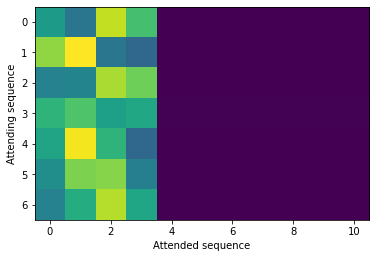

The picture above should be all zeros (dark purple color) starting from the 4th element of the attended sequence


In [3]:
input_size = 9
hidden = 15
num_heads = 3
batch_size = 5
soruce_seq_len = 7
target_seq_len = 11

model = MultiHeadAttention(input_size=input_size, hidden=hidden, num_heads=num_heads)
attending_sequence = torch.randn(batch_size, soruce_seq_len, input_size)
attended_sequence = torch.randn(batch_size, target_seq_len, input_size)

# Imagine the first element of the batch has the length 4 and padded to 7
# attended_sequence[0, 4:, :] = 0
key_padding_mask = torch.zeros(batch_size, target_seq_len)
key_padding_mask[0, 4:] = 1

att, probs = model(
    q=attending_sequence,
    kv=attended_sequence,
    key_padding_mask=key_padding_mask,
    return_attention=True,
)

assert att.shape == (batch_size, soruce_seq_len, hidden), att.shape
assert probs.shape == (batch_size * num_heads, soruce_seq_len, target_seq_len), probs.shape

plt.imshow(torch.softmax(probs[0], dim=-1).detach().numpy())
plt.xlabel("Attended sequence")
plt.ylabel("Attending sequence")
plt.show()

assert probs[0, 0, 3].item() > 1e-10, "You do not attend to regular (non-padded) vectors"
assert probs[0, 0, 4].item() < 1e-10, "You attend to padded vectors"
print("The picture above should be all zeros (dark purple color) starting from the 4th element of the attended sequence")

# Coding tasks 2.1 - 2.2
## Transformer Decoder Layer

Complete `TransformerDecoderLayer(hidden, num_heads, fcn_hidden)` which accepts `FloatTensor[batch_size, seq_len, input_size]` and returns `FloatTensor[batch_size, seq_len, hidden]`.

You need to use `MultiHeadAttention` class here to get the attention and then use residual connections, layer norm, and feedforward networks to build a decoder layer/block.

**Note**: sometimes these are also called Transformer Decoder Block

In [4]:
hidden = 15
num_heads = 3
batch_size = 5
source_seq_len = 7
target_seq_len = 11
fcn_hidden = 71

model = TransformerDecoderLayer(hidden=hidden, num_heads=num_heads, fcn_hidden=fcn_hidden)
decoder_hidden_states = torch.randn(batch_size, target_seq_len, hidden)
encoder_hidden_states = torch.randn(batch_size, source_seq_len, hidden)

output = model(decoder_hidden_states=decoder_hidden_states, encoder_hidden_states=encoder_hidden_states)

assert output.shape == (batch_size, target_seq_len, hidden),\
    f"Expected{(batch_size, target_seq_len, hidden)}, got {output.shape}"

# Coding task 2.3-2.6 - Transformer Encoder-Decoder Model

Now it's time to stack several layers of TransformerEncoderLayer and TransformerDecoderLayer to create TransformerEncoderDecoderModel().
Additionally, you need to first, embed the input ids and add positional encoding to them. The same has to be done for the target ids.

This time your module will not receive a FloatTensor as its input. Instead, it will receive the vocab_ids of the tokens in the text as LongTensor[batch_size, seq_len].

For example, given the text "A red fox in Västernorrlands Län", BPE tokenizer will split it into tokens

```
a red fox in vast ##ern ##or ##rland ##s lan
```

after which you can convert them into vocab_ids and wrap this into a LongTensor

```
[1037, 2417, 4419, 1999, 6565, 11795, 2953, 18324, 2015, 17595]
```

`Tokenizer` object does all of this for you, you just need to remember that your network input is `LongTensor[batch_size, seq_len]` and not `FloatTensor[batch_size, seq_len, hidden]`. It becomes this after the embedding operation.

 Go to transformer_mt/modeling_transformer.py and implement the `TransformerEncoderDecoder` class.

In [5]:
input_size = 9
hidden = 15
num_heads = 3
batch_size = 2
soruce_seq_len = 7
target_seq_len = 11
fcn_hidden = 71
input_vocab_size = 101
output_vocab_size = 103

input_ids = torch.randint(low=1, high=input_vocab_size, size=(batch_size, soruce_seq_len))
decoder_input_ids = torch.randint(low=1, high=output_vocab_size, size=(batch_size, target_seq_len))

model = TransfomerEncoderDecoderModel(
    num_layers=3,
    hidden=hidden,
    num_heads=num_heads,
    fcn_hidden=fcn_hidden,
    src_vocab_size=input_vocab_size,
    tgt_vocab_size=output_vocab_size,
    max_seq_len=12,
)
output = model(input_ids, decoder_input_ids=decoder_input_ids)

assert output.shape == (batch_size, target_seq_len, output_vocab_size),\
    f"Expected{(batch_size, target_seq_len, output_vocab_size)}, got {output.shape}"

In [6]:
# check that .generate (that reilys on ._encode and ._decode) works
output = model.generate(
    input_ids[0].unsqueeze(0),
    bos_token_id=1,
    eos_token_id=2,
    max_length=12,
    pad_token_id=0,
)
print("Passed!")
output

Passed!


tensor([[64, 25, 15, 53, 28, 29, 51, 71, 28, 74, 26, 10]])